In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.sparse.linalg import lsqr
from pylops.basicoperators import *
from pylops.optimization.leastsquares import *

from refrtomo.gaussnewton import gauss_newton
from refrtomo.invert import *
from refrtomo.survey import *


import segyio
from refrtomo.segyshot import SegyShot
from refrtomo.VolvoHelper import *
from refrtomo.picking import *

# Volvo Dataset

Local regular axis:
 ox=0.000000, dx=49.793406 nx=241
 oy=-0.000000, dy=49.540976 ny=109


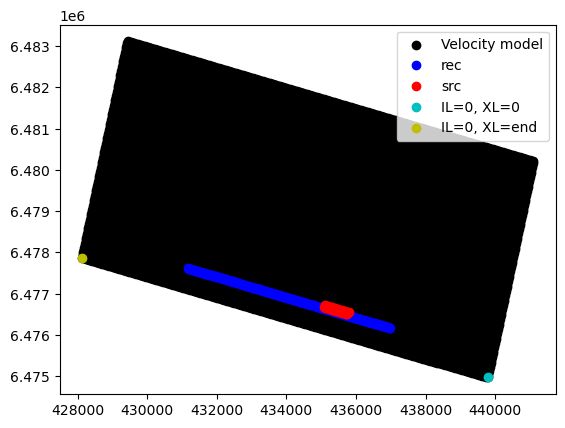

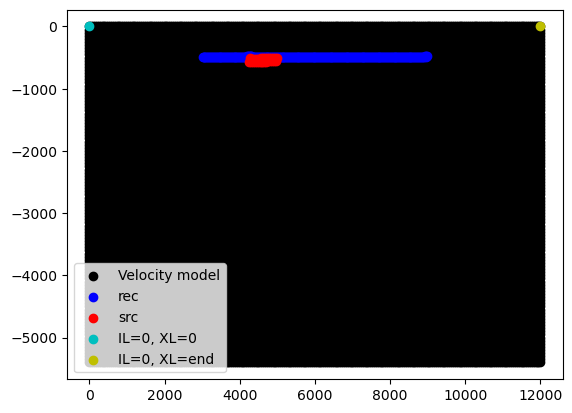

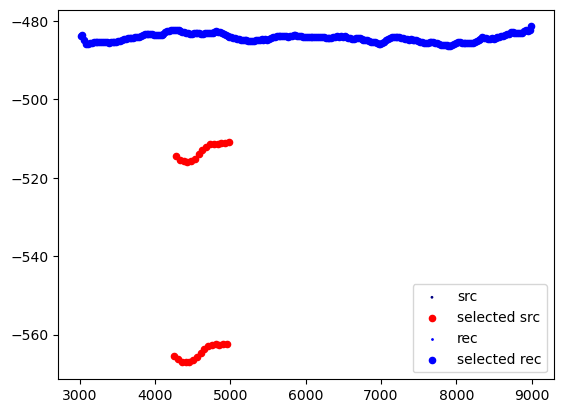

In [2]:
inputfile = '../data/ST10010_1150780_40203_2dline1.sgy'
velfile = '../data/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'

f = segyio.open(inputfile, ignore_geometry=True)
t = f.samples

nTraces =  f.bin[segyio.BinField.Traces]

# to call one trace
tr = f.trace[0]

# Pressure shot gather (note that for each receiver the data is organized as follows: P,VZ,VX,VY.
# So we take every 4th trace)

fv = segyio.open(velfile)

# Depth axes
z = fv.samples
dz = z[1] - z[0]
il, xl = fv.ilines, fv.xlines
# Velocity model
vmod = segyio.cube(velfile)

# first shot gather
d = segyio.collect(f.trace[:240*4])
PData = d[::4]


sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
nRec = sg.nrec
nT = sg.nt
sg.interpret()
# local regular axis
vdx, vnx, vdy, vny = sg.rotategeometry(velfile=velfile, plotflag=1)
sg.showgeometry(local=True)

v_x = np.arange(0, vnx * vdx, vdx)
v_y = - np.arange(0, vny * vdy, vdy)
# Compute the indices in v_y that closely match each value in sg.recy_local
il_rec_idx = np.abs(sg.recy_local[:, None] - v_y).argmin(axis=1)
il_src_idx = np.abs(sg.srcy_local[:, None] - v_y).argmin(axis=1)

vmod2d = vmod[il_rec_idx[0]]

# print(f"3D velocity model size {vmod.shape}")
# print(f"Number of sources = {len(sg.srcx)}")

### Rotated velocity model with sources and Receivers 

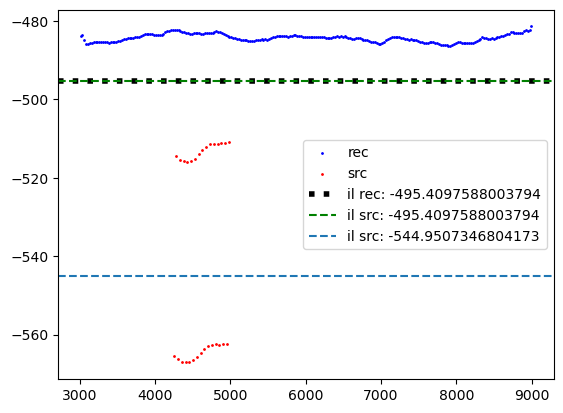

In [3]:

# fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
# im = axs[0].imshow(vmod[50].T, extent=(xl[0], xl[-1], z[-1], z[0]), cmap='jet')
# axs[0].axvline(xl[120], color='w', linestyle='--')
# 
# axs[0].set_title('Migration velocity model', fontweight='bold')
# axs[0].set_xlabel('XL')
# axs[0].set_ylabel('Z[m]')
# axs[0].axis('tight')
# cbar = fig.colorbar(im, ax=axs[0]) 
# axs[1].plot(vmod[50, 120], z, 'k')
# plt.tight_layout();

plt.figure()
plt.scatter(sg.recx_local, sg.recy_local, color='b', s=1, label='rec')
plt.scatter(sg.srcx_local, sg.srcy_local, c='r', s=1, cmap='jet', label='src')
plt.axhline(v_y[il_rec_idx[0]], linestyle=":", c='black', linewidth=4, label=f"il rec: {v_y[il_rec_idx[0]]}")
plt.axhline(v_y[il_src_idx[1]], linestyle="--", c='g', label=f"il src: {v_y[il_src_idx[1]]}")
plt.axhline(v_y[il_src_idx[0]], linestyle="--", label=f"il src: {v_y[il_src_idx[0]]}")
plt.legend()

In [10]:
il_rec_idx[0]

10

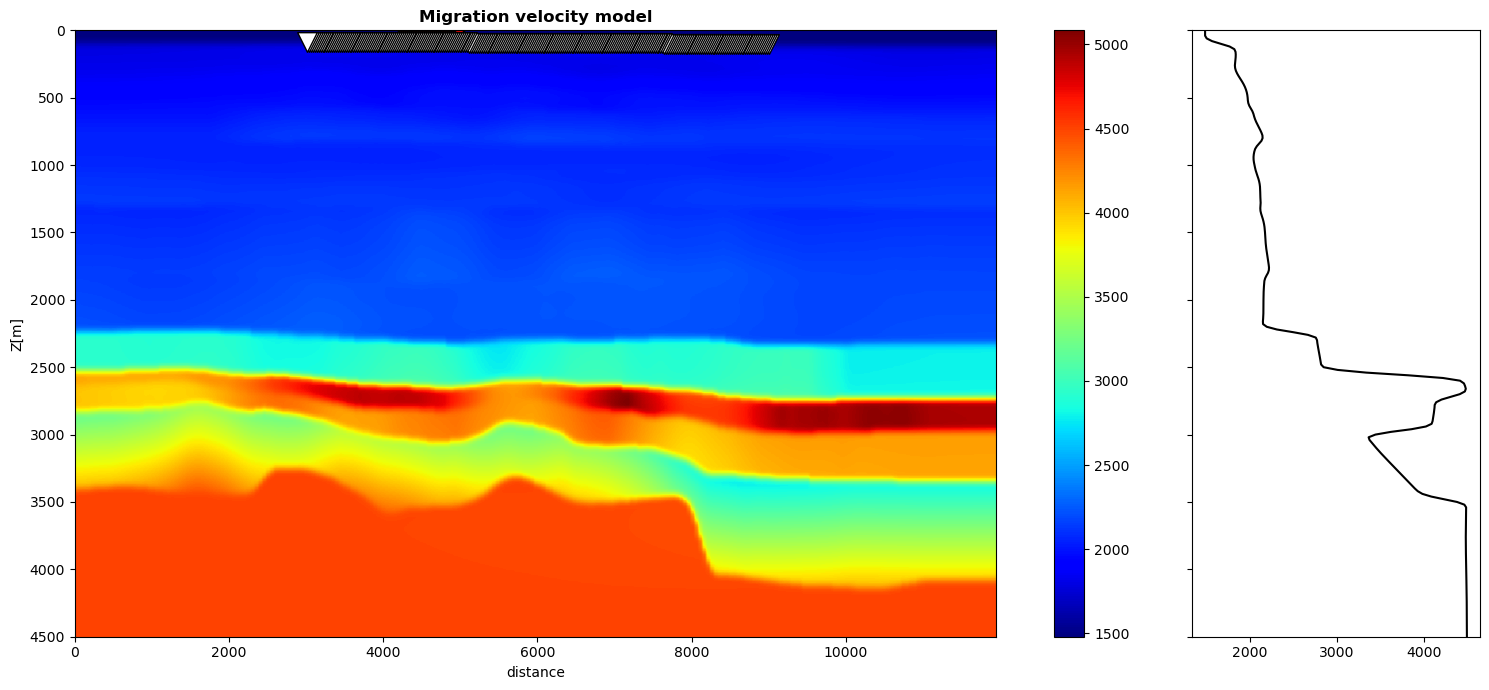

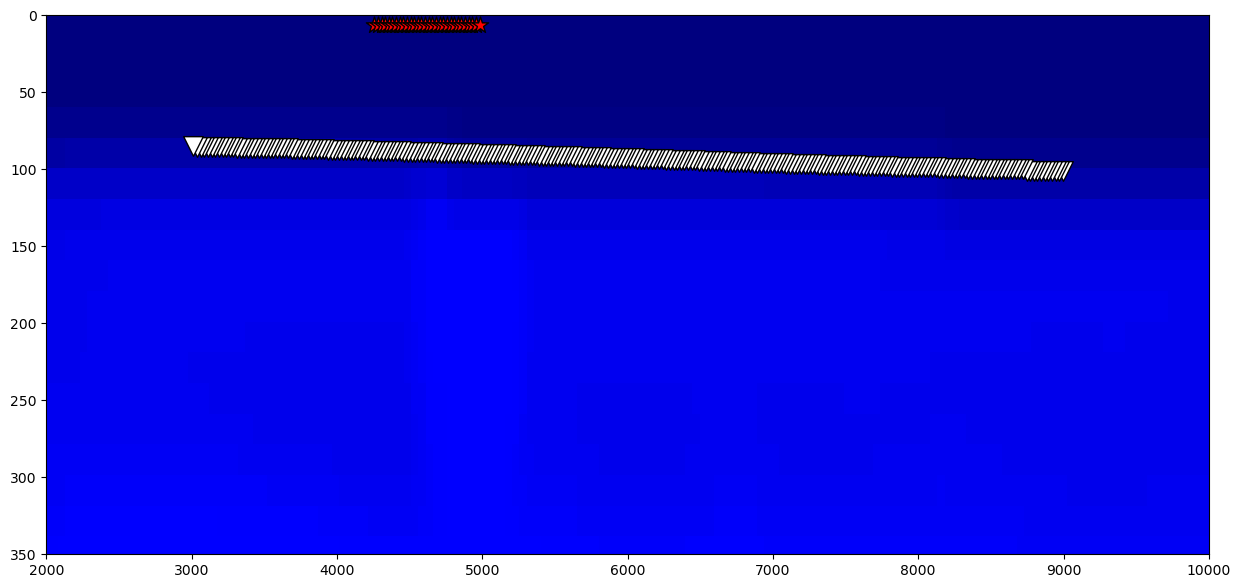

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
im = axs[0].imshow(vmod[il_rec_idx[0]].T, extent=(v_x[0], v_x[-1], z[-1], z[0]), cmap='jet')
# axs[0].axvline(xl[120], color='w', linestyle='--')
axs[0].scatter(sg.srcx_local, sg.srcz, marker='*', s=150, c='r', edgecolors='k')
axs[0].scatter(sg.recx_local, sg.recz, marker='v', s=200, c='w', edgecolors='k')

axs[0].set_title('Migration velocity model', fontweight='bold')
axs[0].set_xlabel('distance')
axs[0].set_ylabel('Z[m]')
axs[0].axis('tight')
cbar = fig.colorbar(im, ax=axs[0]) 
axs[1].plot(vmod[50, 120], z, 'k')
plt.tight_layout();

plt.figure(figsize=(15, 7))
plt.imshow(vmod[50].T, extent=(v_x[0], v_x[-1], z[-1], z[0]), cmap='jet')
plt.scatter(sg.srcx_local, sg.srcz, marker='*', s=150, c='r', edgecolors='k')
plt.scatter(sg.recx_local, sg.recz, marker='v', s=200, c='w', edgecolors='k')

plt.xlim(2000, 10000)
plt.ylim(350, 0) 
plt.gca().set_aspect('auto')
# plt.gca().invert_yaxis() 

## Ray Tracing 

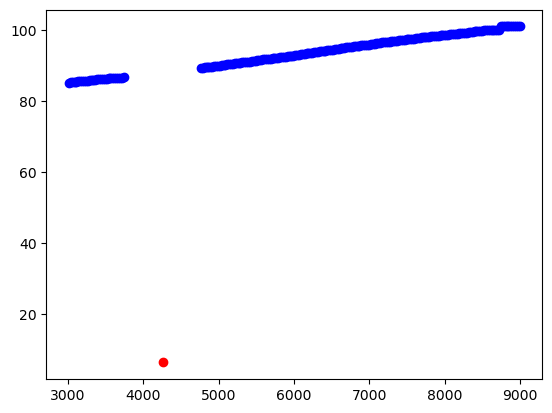

In [5]:
srcs = np.vstack((sg.srcx_local[0], sg.srcz[0]))
recs = np.vstack((sg.recx_local, sg.recz))

survey = survey_geom(srcs, recs, minoffset=500)
display_survey(survey)

In [6]:
lmax = 1e3
nl = 20000
thetas = np.hstack([np.arange(-85, -40, 0.05), np.arange(40, 85, 0.05)])
avasurvey = survey_raytrace(survey, vmod2d.T, v_x, z, lmax, nl, thetas, dzout=5., ray_rec_mindistance=5.)

In [11]:
lmax = 1e3
nl = 2000
# Raytrace
rays, rays_turning, thetas_turning = raytrace(vmod2d.T, v_x, z, vdx, dz, 
                                              lmax, nl, (sg.srcx_local[0], sg.srcz[0]), 
                                              thetas, dzout=1., debug=True)

raytrace: 1800 Shot rays, 1109 Turning rays...


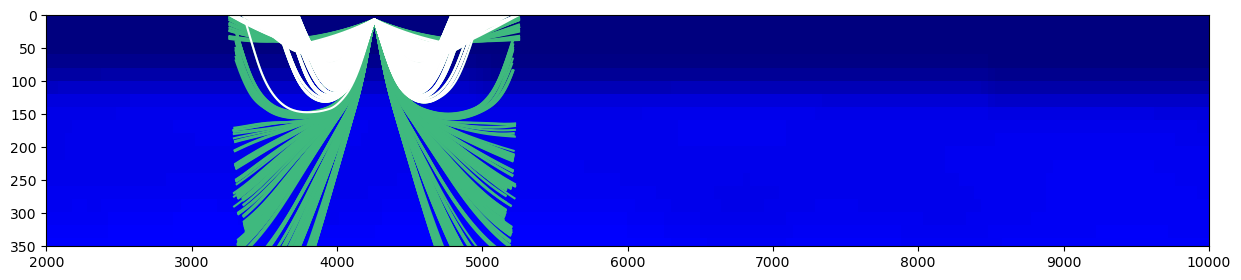

In [13]:
plt.figure(figsize=(15, 3))
plt.imshow(vmod2d.T, cmap='jet', extent = (v_x[0], v_x[-1], z[-1], z[0]))
# plt.scatter(survey[ns//2].rec[0], survey[ns//2].rec[1], marker='v', s=150, c='b', edgecolors='k')
# plt.scatter(survey[ns//2].src[0], survey[ns//2].src[1], marker='*', s=150, c='r', edgecolors='k')
for ray in rays:
    plt.plot(ray[:,0], ray[:,1], '#3FB97E')
for ray in rays_turning:
    plt.plot(ray[:,0], ray[:,1], 'w')
plt.axis('tight');
plt.xlim(2000, 10000)
plt.ylim(350, 0) 
plt.gca().set_aspect('auto')